# 01 - Pré-processamento dos dados CHIRPS

Este notebook realiza:
1. Leitura de arquivos mensais CHIRPS em formato `.tif`.

2. Empilhamento de dados `(tempo, lat, lon)` usando `xarray`.

3. Verificação de consistência temporal e espacial.

4. Exportação para `NetCDF` para agilizar análises posteriores.

Os arquivos `.tif` devem estar nomeados como:

`chirps_YYYY_M.tif`

In [1]:
import glob
import os
import numpy as np
import rasterio
import xarray as xr
import matplotlib.pyplot as plt


In [2]:
# Caminho para os arquivos .tif
pasta_tifs = "dataset/chirps_data/"

# Padrão esperado dos arquivos
padrao_nomes = "chirps_*.tif"

# Nome do arquivo NetCDF de saída
saida_nc = "dataset/netcdf_data/chirps_mensal_1981_2023.nc"


In [3]:
# Listagem e verificação dos arquivos
arquivos = sorted(glob.glob(os.path.join(pasta_tifs, padrao_nomes)))

print(f"Total de arquivos encontrados: {len(arquivos)}")
print("Primeiro arquivo:", arquivos[:1])
print("Último arquivo:", arquivos[-1:])


Total de arquivos encontrados: 516
Primeiro arquivo: ['dataset/chirps_data/chirps_1981_1.tif']
Último arquivo: ['dataset/chirps_data/chirps_2023_9.tif']


In [4]:
# Função para carregar e empilhar os tifs
def carregar_tifs_para_xarray(lista_arquivos):
    dados = []
    tempo = []
    profile = None

    for arq in lista_arquivos:
        nome = os.path.basename(arq)
        _, ano, mes = nome.replace(".tif","").split("_")
        tempo.append(f"{ano}-{int(mes):02d}")

        with rasterio.open(arq) as src:
            arr = src.read(1)
            profile = src.profile
            dados.append(arr)

    # Empilhar em array 3D: (tempo, y, x)
    dados = np.stack(dados)

    # Coordenadas espaciais a partir do transform do raster
    transform = profile['transform']
    width = profile['width']
    height = profile['height']
    lon = np.array([transform[2] + i*transform[0] for i in range(width)])
    lat = np.array([transform[5] + j*transform[4] for j in range(height)])

    # Criar DataArray com xarray
    xr_data = xr.DataArray(
        dados,
        dims=("time", "lat", "lon"),
        coords={
            "time": np.array(tempo, dtype="datetime64[M]"),
            "lat": lat,
            "lon": lon
        },
        name="precip"
    )
    return xr_data

In [5]:
#Executar carregamento dos dados
ds = carregar_tifs_para_xarray(arquivos)

print(f"Dados carregados: {ds.shape[0]} arquivos, com {ds.shape[1]} latitudes e {ds.shape[2]} longitudes")

Dados carregados: 516 arquivos, com 267 latitudes e 188 longitudes


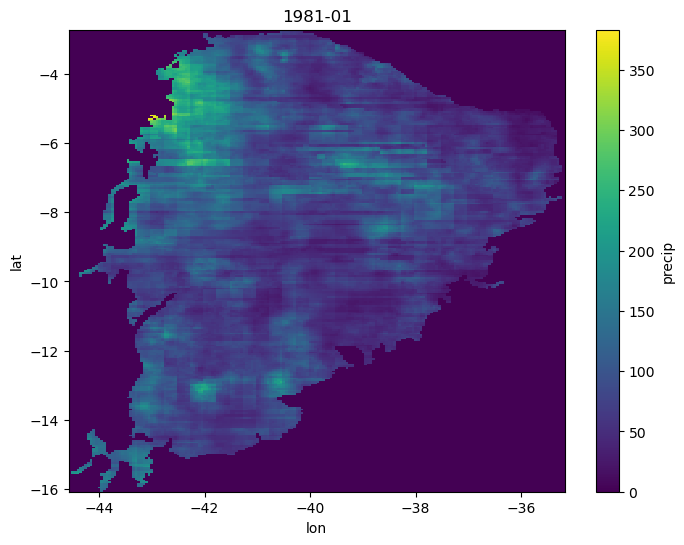

In [6]:
# Plot de exemplo

ds.isel(time=0).plot(figsize=(8,6))
plt.title(str(ds.time.values[0])[:7])
plt.show()

In [7]:
# Salvando em NetCDF
os.makedirs(os.path.dirname(saida_nc), exist_ok=True)
ds.to_netcdf(saida_nc)
print(f"Arquivo NetCDF salvo em: {saida_nc}")

Arquivo NetCDF salvo em: dataset/netcdf_data/chirps_mensal_1981_2023.nc
